In [99]:
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from scipy import stats
import seaborn as sns 

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

In [100]:
# 폰트 파일의 경로 지정
font_path = r'C:\Windows\Fonts\gulim.ttc'

In [101]:
# matplotlib 패키지에 한글 폰트 설정
myFont = fm.FontProperties(fname = font_path).get_name()
mpl.rc('font', family = myFont)

In [102]:
file_data = '../DATA/HousingData.csv'

In [103]:
houseDF = pd.read_csv(file_data)
houseDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [104]:
houseDF.shape

(506, 14)

In [105]:
houseDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [106]:
# 중복데이터 없음
houseDF.drop_duplicates().shape

(506, 14)

In [107]:
houseDF.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [108]:
# 결측치가 하나라도 있는 행이 112개
houseDF.dropna().shape

(394, 14)

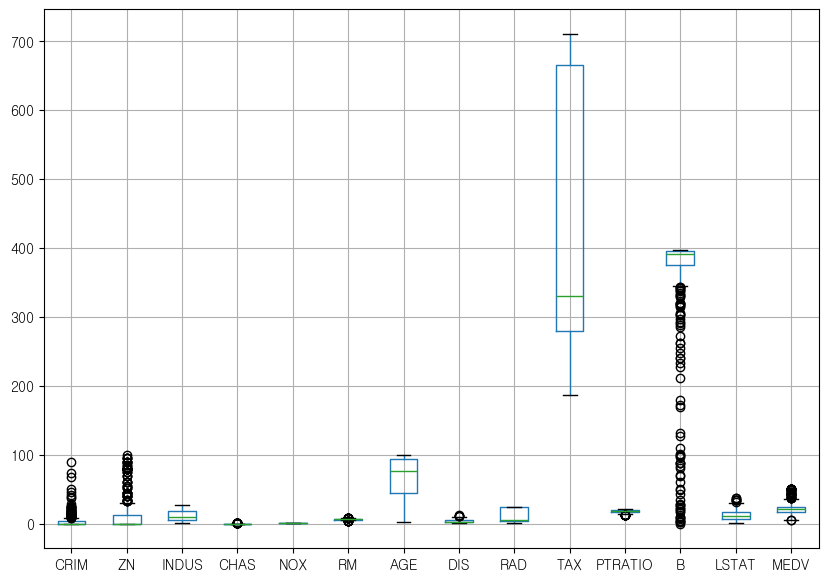

In [109]:
houseDF.boxplot(figsize = (10, 7))
plt.show()

In [110]:
houseDF.MEDV.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

In [111]:
houseDF.MEDV.value_counts()

MEDV
50.0    16
25.0     8
22.0     7
21.7     7
23.1     7
        ..
32.9     1
34.6     1
30.3     1
33.3     1
8.1      1
Name: count, Length: 229, dtype: int64

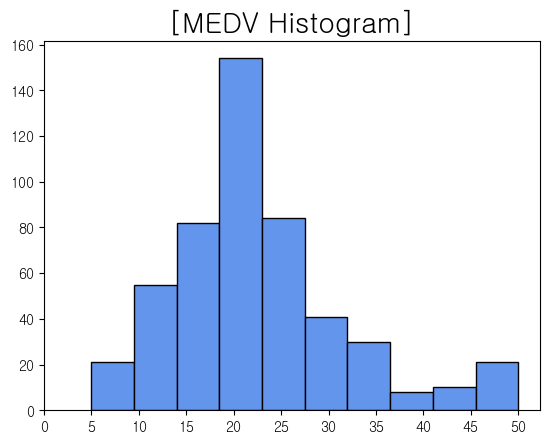

In [112]:
plt.hist(houseDF.MEDV, bins = 10, edgecolor = 'black', color = 'cornflowerblue')
plt.xticks(np.linspace(0, 50, 11))
plt.title('[MEDV Histogram]', size = 20)
plt.show()

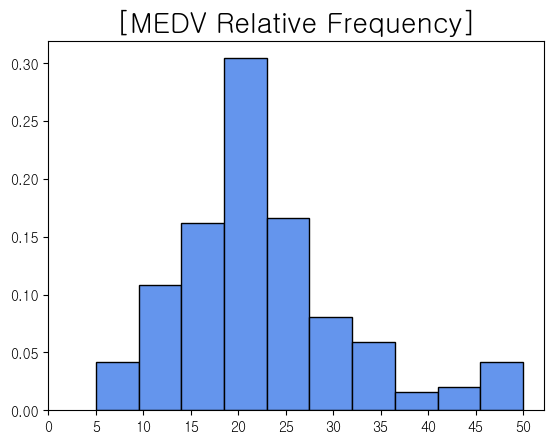

In [113]:
weights = np.ones_like(houseDF.MEDV) / houseDF.shape[0]
plt.hist(houseDF.MEDV, bins = 10, edgecolor = 'black', weights = weights, color = 'cornflowerblue')
plt.xticks(np.linspace(0, 50, 11))
plt.title('[MEDV Relative Frequency]', size = 20)
plt.show()

In [114]:
# 결측치가 있는 특성 목록
houseDF.columns[houseDF.isna().sum() != 0]

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT'], dtype='object')

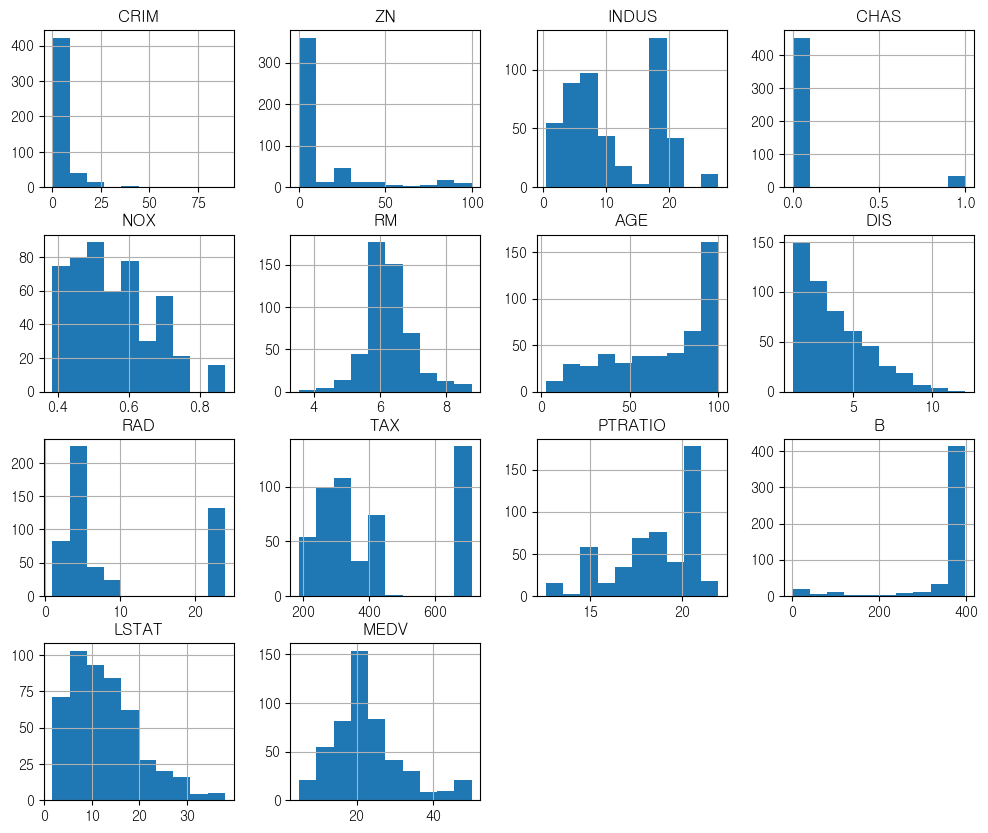

In [115]:
houseDF.hist(figsize = (12, 10))
plt.show()

In [116]:
houseDF.describe().round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.00,486.00,486.00,486.00,506.00,506.00,486.00,506.00,506.00,506.00,506.00,506.00,486.00,506.00
mean,3.61,11.21,11.08,0.07,0.55,6.28,68.52,3.80,9.55,408.24,18.46,356.67,12.72,22.53
std,8.72,23.39,6.84,0.26,0.12,0.70,28.00,2.11,8.71,168.54,2.16,91.29,7.16,9.20
min,0.01,0.00,0.46,0.00,0.38,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.18,2.10,4.00,279.00,17.40,375.38,7.12,17.02
50%,0.25,0.00,9.69,0.00,0.54,6.21,76.80,3.21,5.00,330.00,19.05,391.44,11.43,21.20
75%,3.56,12.50,18.10,0.00,0.62,6.62,93.98,5.19,24.00,666.00,20.20,396.22,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


In [117]:
# 각 특성의 고유값 개수
houseDF.nunique()

CRIM       484
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        348
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      438
MEDV       229
dtype: int64

In [118]:
houseDF.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.191178,0.401863,-0.054355,0.417130,-0.219150,0.354342,-0.374166,0.624765,0.580595,0.281110,-0.381411,0.444943,-0.391363
ZN,-0.191178,1.000000,-0.531871,-0.037229,-0.513704,0.320800,-0.563801,0.656739,-0.310919,-0.312371,-0.414046,0.171303,-0.414193,0.373136
INDUS,0.401863,-0.531871,1.000000,0.059859,0.764866,-0.390234,0.638431,-0.711709,0.604533,0.731055,0.390954,-0.360532,0.590690,-0.481772
CHAS,-0.054355,-0.037229,0.059859,1.000000,0.075097,0.104885,0.078831,-0.093971,0.001468,-0.032304,-0.111304,0.051264,-0.047424,0.181391
NOX,0.417130,-0.513704,0.764866,0.075097,1.000000,-0.302188,0.731548,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.582641,-0.427321
RM,-0.219150,0.320800,-0.390234,0.104885,-0.302188,1.000000,-0.247337,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.614339,0.695360
AGE,0.354342,-0.563801,0.638431,0.078831,0.731548,-0.247337,1.000000,-0.744844,0.458349,0.509114,0.269226,-0.275303,0.602891,-0.394656
DIS,-0.374166,0.656739,-0.711709,-0.093971,-0.769230,0.205246,-0.744844,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.493328,0.249929
RAD,0.624765,-0.310919,0.604533,0.001468,0.611441,-0.209847,0.458349,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.479541,-0.381626
TAX,0.580595,-0.312371,0.731055,-0.032304,0.668023,-0.292048,0.509114,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.536110,-0.468536


In [119]:
def print_feature(nrows, ncols, target, features, corrs, df = houseDF):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_18632\3322633811.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')


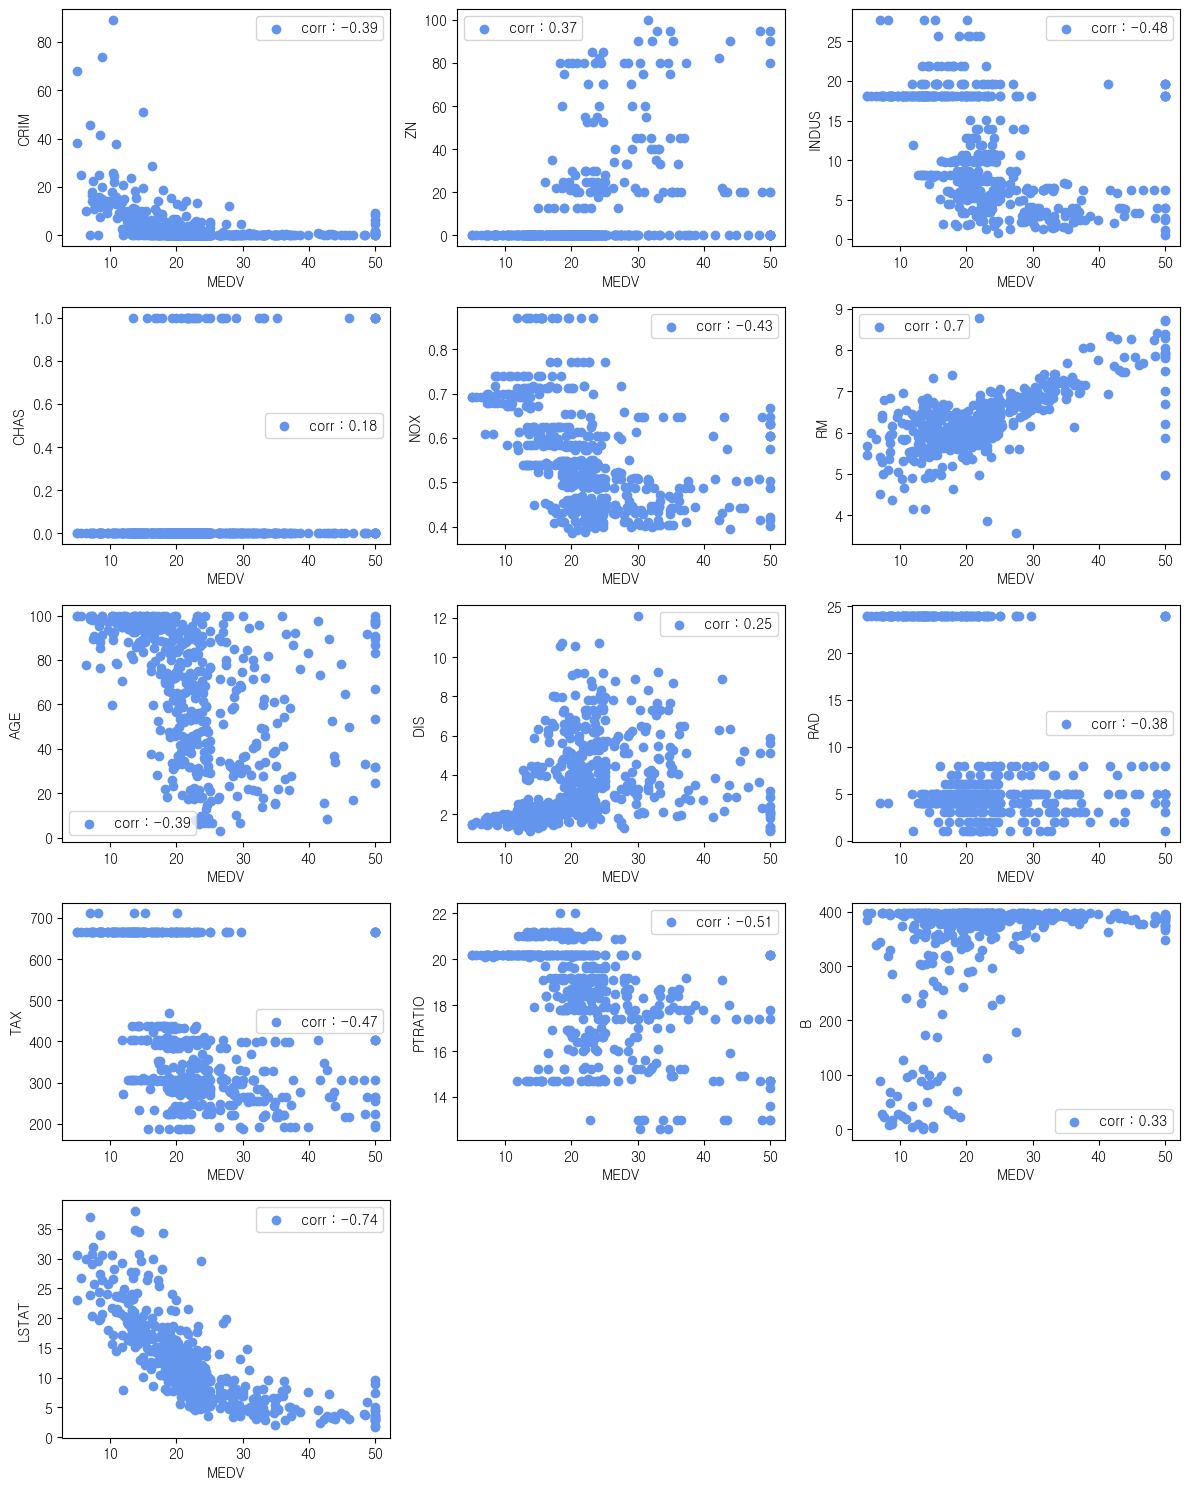

In [120]:
corrs = houseDF.corr()['MEDV']
plt.figure(figsize = (12, 15))
print_feature(5, 3, 'MEDV', houseDF.columns[:-1], corrs[:-1])

In [121]:
houseDF.corr()['CHAS']

CRIM      -0.054355
ZN        -0.037229
INDUS      0.059859
CHAS       1.000000
NOX        0.075097
RM         0.104885
AGE        0.078831
DIS       -0.093971
RAD        0.001468
TAX       -0.032304
PTRATIO   -0.111304
B          0.051264
LSTAT     -0.047424
MEDV       0.181391
Name: CHAS, dtype: float64

In [122]:
# 범주형 데이터 특성'CHAS'와 수치형 데이터 특성 MEDV의 상관계수
houseDF.dropna(subset = ['CHAS']).shape
stats.pointbiserialr(houseDF.dropna(subset = ['CHAS']).MEDV, houseDF.dropna(subset = ['CHAS']).CHAS).statistic

0.18139139285851202

In [123]:
corrs = houseDF.corr()['MEDV'][:-1]
corrs.abs() > 0.4

CRIM       False
ZN         False
INDUS       True
CHAS       False
NOX         True
RM          True
AGE        False
DIS        False
RAD        False
TAX         True
PTRATIO     True
B          False
LSTAT       True
Name: MEDV, dtype: bool

In [199]:
houseDF[houseDF.columns[:-1]]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48


In [196]:
houseDF.nunique()

CRIM       484
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        348
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      438
MEDV       229
dtype: int64

In [200]:
houseDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


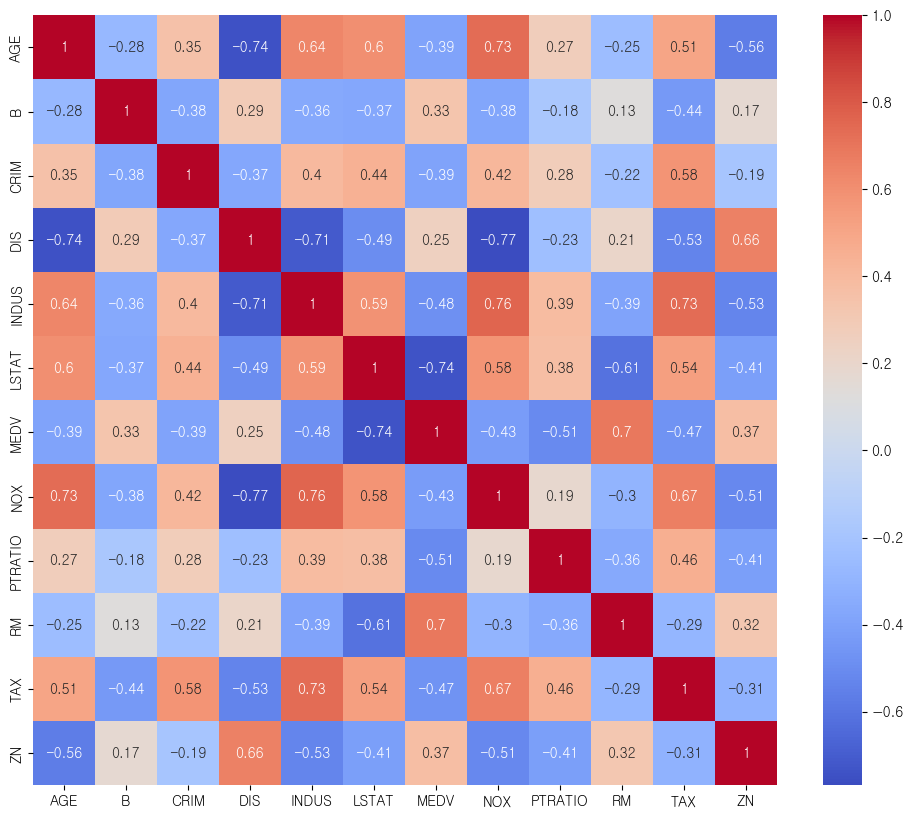

In [201]:
# 상관행렬 시각화, 범주형 데이터 RAD, ZN 피처 제외
# cmap = sns.light_palette("darkgray", as_cmap = True)  
plt.figure(figsize = (12, 10))
sns.heatmap(houseDF[houseDF.columns.difference(['CHAS', 'RAD'])].corr(), annot = True, cmap = 'coolwarm')
plt.show()

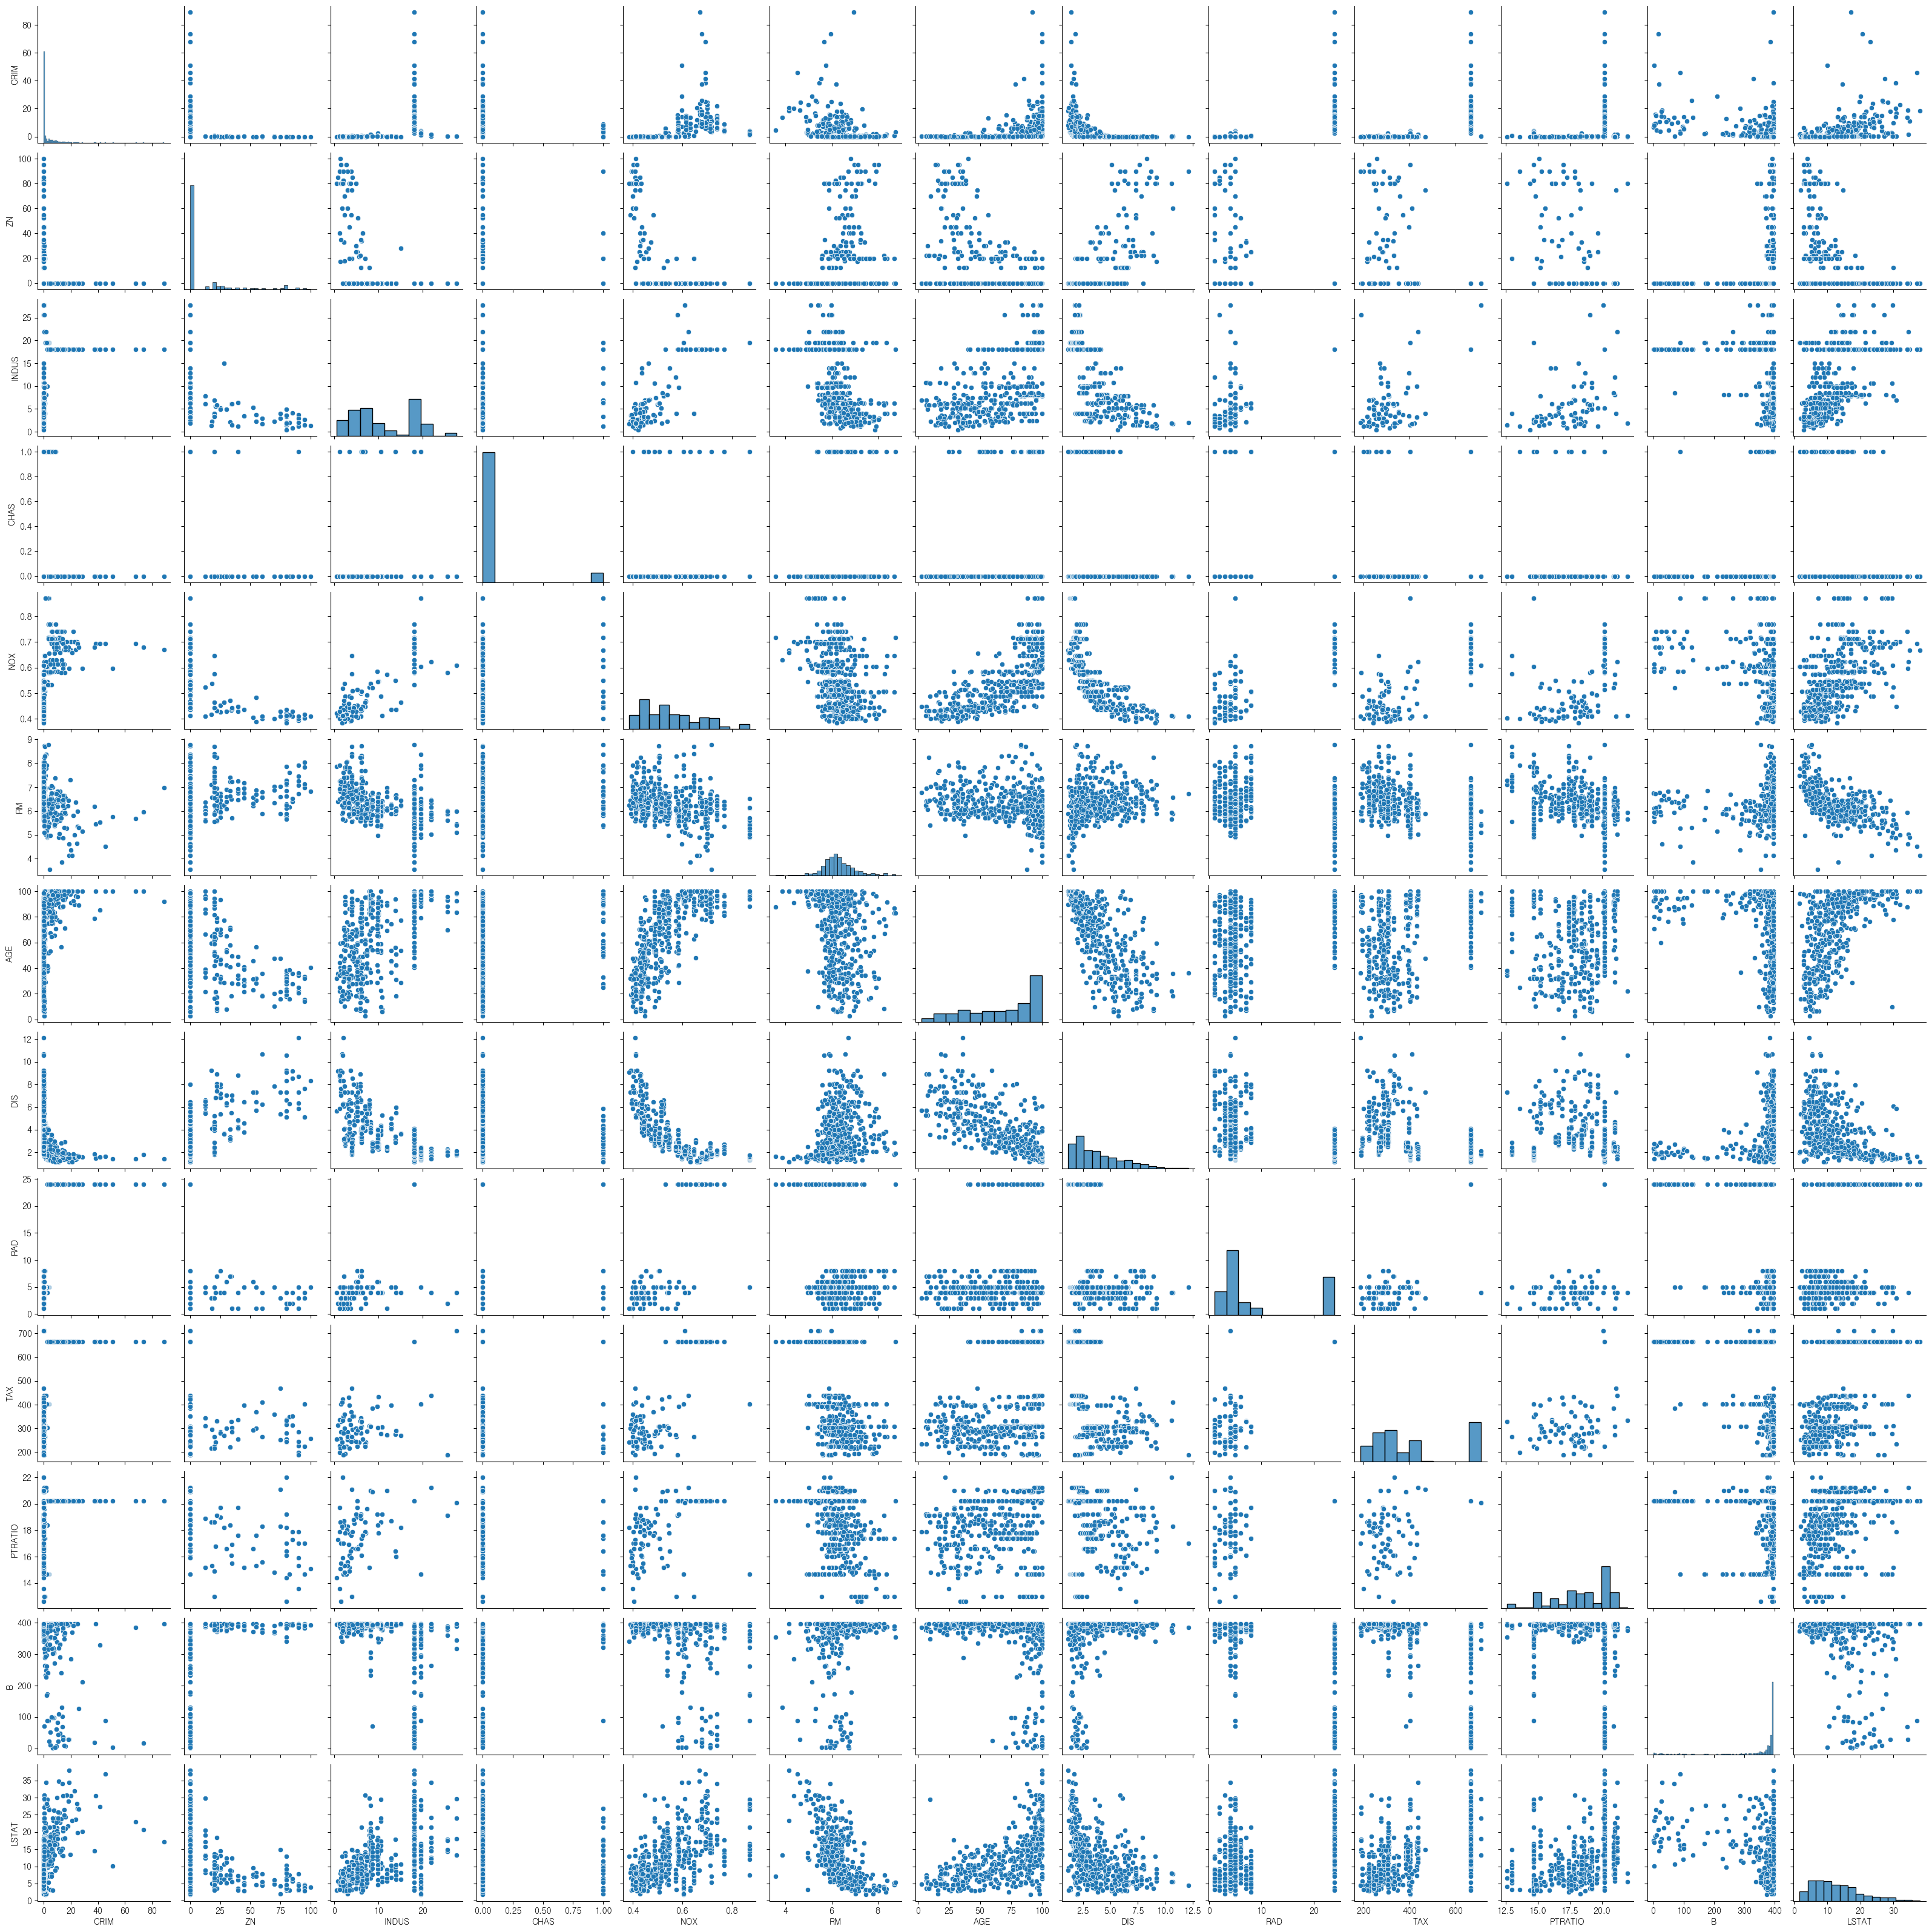

In [126]:
# 변수끼리 산점도를 시각화
sns.pairplot(houseDF[houseDF.columns[:-1]])
plt.show()

In [127]:
corrs[corrs.abs() > 0.4]

INDUS     -0.481772
NOX       -0.427321
RM         0.695360
TAX       -0.468536
PTRATIO   -0.507787
LSTAT     -0.735822
Name: MEDV, dtype: float64

In [128]:
# MEDV와 상관계수가 0.4 보다 큰 특성이름 추출
corrs[corrs.abs() > 0.4].index

Index(['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')

In [129]:
# MEDV와 상관계수가 0.4 보다 큰 특성들의 상관계수를 조사하여 다중공선성 체크
feature = corrs[corrs.abs() > 0.4].index
houseDF[feature].corr()


,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
INDUS,1.000000,0.764866,-0.390234,0.731055,0.390954,0.590690
NOX,0.764866,1.000000,-0.302188,0.668023,0.188933,0.582641
RM,-0.390234,-0.302188,1.000000,-0.292048,-0.355501,-0.614339
TAX,0.731055,0.668023,-0.292048,1.000000,0.460853,0.536110
PTRATIO,0.390954,0.188933,-0.355501,0.460853,1.000000,0.375966
LSTAT,0.590690,0.582641,-0.614339,0.536110,0.375966,1.000000


In [130]:
houseDF[feature].corr() >= 0.5

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
INDUS,True,True,False,True,False,True
NOX,True,True,False,True,False,True
RM,False,False,True,False,False,False
TAX,True,True,False,True,False,True
PTRATIO,False,False,False,False,True,False
LSTAT,True,True,False,True,False,True


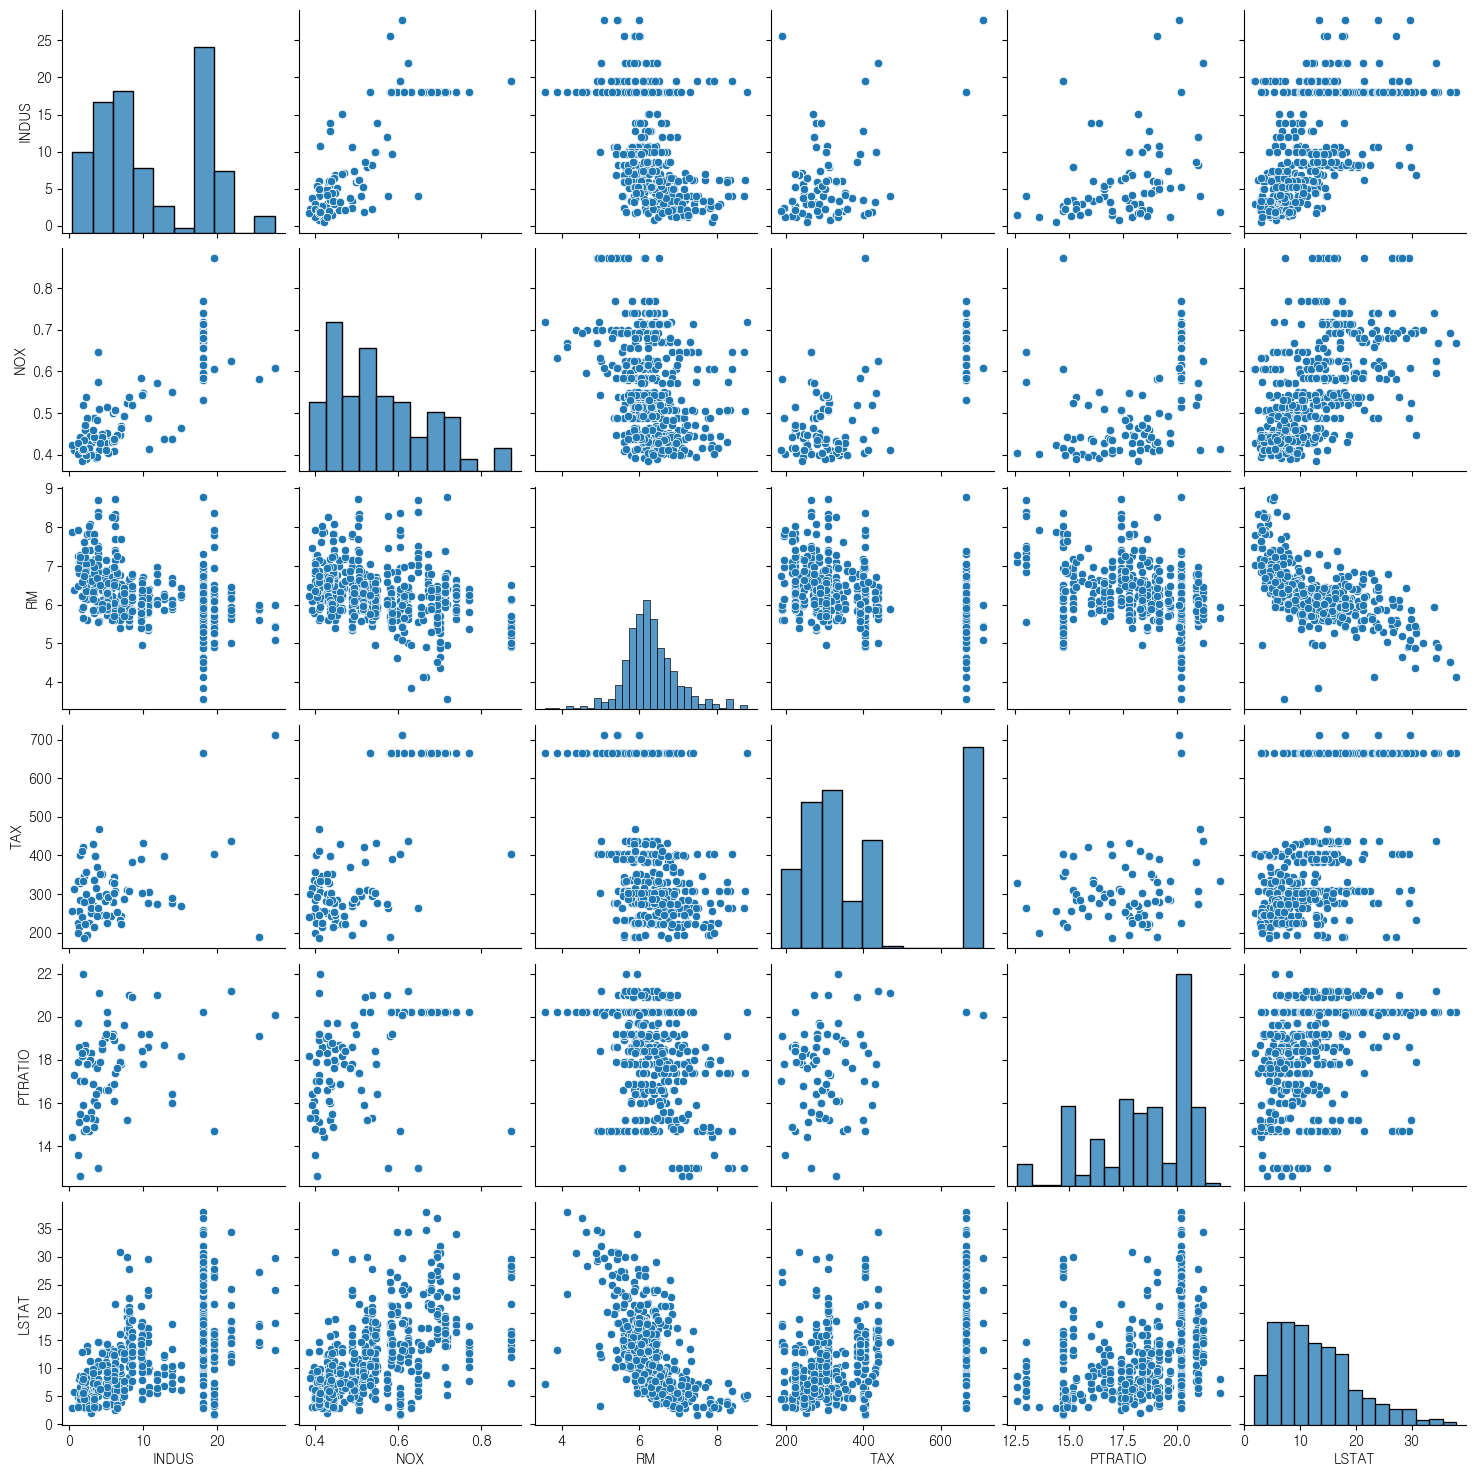

In [131]:
# 변수끼리 산점도를 시각화
sns.pairplot(houseDF[feature])
plt.show()

In [132]:
feature = corrs[corrs.abs() > 0.4].index
houseDF[feature]

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
0,2.31,0.538,6.575,296,15.3,4.98
1,7.07,0.469,6.421,242,17.8,9.14
2,7.07,0.469,7.185,242,17.8,4.03
3,2.18,0.458,6.998,222,18.7,2.94
4,2.18,0.458,7.147,222,18.7,NaN
...,...,...,...,...,...,...
501,11.93,0.573,6.593,273,21.0,NaN
502,11.93,0.573,6.120,273,21.0,9.08
503,11.93,0.573,6.976,273,21.0,5.64
504,11.93,0.573,6.794,273,21.0,6.48


In [133]:
featureDF = houseDF[feature]
targetSR = houseDF['MEDV']

print(f'featureDF => {featureDF.shape}\n\ntargetSR => {targetSR.shape}')

featureDF => (506, 6)

targetSR => (506,)


In [134]:
# 결측치가 하나라도 있는 행은 제거한 나머지 추출
featureDF = featureDF.dropna()

# 타겟시리즈에 위 피처데이터의 인덱스 정보를 넣어서 추출
targetSR = targetSR[featureDF.index]

# 인덱스 재조정 => 0부터 순차적으로
featureDF.reset_index(drop = True, inplace = True)
targetSR.reset_index(drop = True, inplace = True)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 6)

In [136]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [137]:
std_scaler.fit(X_train)
scaled_X_train = std_scaler.transform(X_train)
scaled_X_test = std_scaler.transform(X_test)

In [138]:
# 성능 안 좋다.
# mm_scaler.fit(X_train)
# scaled_X_train = mm_scaler.transform(X_train)
# scaled_X_test = mm_scaler.transform(X_test)

In [139]:
lr_model = LinearRegression()
lr_model.fit(scaled_X_train, y_train)
lr_model.score(scaled_X_test, y_test)

0.6201441230779379

In [140]:
# 모델 파라미터
print(lr_model.coef_, lr_model.intercept_)

[ 0.94380598 -0.56639525  3.41289973 -0.80041571 -1.83837737 -3.89645641] 22.38440860215054


In [141]:
y_pre1 = lr_model.predict(scaled_X_test)

In [142]:
print(r2_score(y_pre1, y_test), mean_absolute_error(y_pre1, y_test), mean_squared_error(y_pre1, y_test))

0.5175757843826345 4.089772028958008 37.7005427416308


- 릿지 회귀

In [143]:
ridge_model = Ridge(max_iter = 10000, alpha = 60)
ridge_model.fit(scaled_X_train, y_train)
ridge_model.score(scaled_X_test, y_test)

0.6306926186983159

In [144]:
# 모델 파라미터
print(ridge_model.n_iter_, ridge_model.coef_, ridge_model.intercept_)

None [ 0.22247672 -0.48868116  3.1101043  -0.70001825 -1.68318363 -3.2713776 ] 22.38440860215054


In [145]:
y_pre2 = ridge_model.predict(scaled_X_test)

In [146]:
print(r2_score(y_pre2, y_test), mean_absolute_error(y_pre2, y_test), mean_squared_error(y_pre2, y_test))

0.43986127855651036 4.016825680410486 36.653608801268035


- 라쏘 회귀

In [147]:
lasso_model = Lasso(max_iter = 10000, alpha = 0.1)
lasso_model.fit(scaled_X_train, y_train)
lasso_model.score(scaled_X_test, y_test)

0.6275452062453001

In [148]:
# 모델 파라미터
print(lasso_model.n_iter_, lasso_model.coef_, lasso_model.intercept_)

26 [ 0.23794395 -0.16310437  3.29714458 -0.5621727  -1.69368906 -3.86433802] 22.38440860215054


In [149]:
y_pre3 = lasso_model.predict(scaled_X_test)

In [150]:
print(r2_score(y_pre3, y_test), mean_absolute_error(y_pre3, y_test), mean_squared_error(y_pre3, y_test))

0.5016881875130921 4.049186252979375 36.96598821914607


#### 피처 추가

In [151]:
poly = PolynomialFeatures(degree = 2)
poly.fit(featureDF)
poly_data = poly.transform(featureDF)

In [152]:
poly_data.shape

(466, 28)

In [153]:
poly_feature_names = poly.get_feature_names_out(featureDF.columns)
poly_feature_names

array(['1', 'INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT', 'INDUS^2',
       'INDUS NOX', 'INDUS RM', 'INDUS TAX', 'INDUS PTRATIO',
       'INDUS LSTAT', 'NOX^2', 'NOX RM', 'NOX TAX', 'NOX PTRATIO',
       'NOX LSTAT', 'RM^2', 'RM TAX', 'RM PTRATIO', 'RM LSTAT', 'TAX^2',
       'TAX PTRATIO', 'TAX LSTAT', 'PTRATIO^2', 'PTRATIO LSTAT',
       'LSTAT^2'], dtype=object)

In [154]:
featureDF.columns

Index(['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')

In [155]:
new_featureDF = pd.DataFrame(poly_data, columns = poly_feature_names)
new_featureDF.head()

,1,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,INDUS^2,INDUS NOX,INDUS RM,...,RM^2,RM TAX,RM PTRATIO,RM LSTAT,TAX^2,TAX PTRATIO,TAX LSTAT,PTRATIO^2,PTRATIO LSTAT,LSTAT^2
0,1.0,2.31,0.538,6.575,296.0,15.3,4.98,5.3361,1.24278,15.18825,...,43.230625,1946.200,100.5975,32.74350,87616.0,4528.8,1474.08,234.09,76.194,24.8004
1,1.0,7.07,0.469,6.421,242.0,17.8,9.14,49.9849,3.31583,45.39647,...,41.229241,1553.882,114.2938,58.68794,58564.0,4307.6,2211.88,316.84,162.692,83.5396
2,1.0,7.07,0.469,7.185,242.0,17.8,4.03,49.9849,3.31583,50.79795,...,51.624225,1738.770,127.8930,28.95555,58564.0,4307.6,975.26,316.84,71.734,16.2409
3,1.0,2.18,0.458,6.998,222.0,18.7,2.94,4.7524,0.99844,15.25564,...,48.972004,1553.556,130.8626,20.57412,49284.0,4151.4,652.68,349.69,54.978,8.6436
4,1.0,2.18,0.458,6.430,222.0,18.7,5.21,4.7524,0.99844,14.01740,...,41.344900,1427.460,120.2410,33.50030,49284.0,4151.4,1156.62,349.69,97.427,27.1441


In [156]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, degree, my_model = LinearRegression(), threshold = 0.4, test_size = 0.2, random_state = 42, df = houseDF):
    corrs = df.corr()['MEDV'][:-1]
    feature = corrs[corrs.abs() > threshold].index
    featureDF = df[feature]
    targetSR = df[target]
    # 결측치가 하나라도 있는 행은 제거한 나머지 추출
    featureDF = featureDF.dropna()

    # 타겟시리즈에 위 피처데이터의 인덱스 정보를 넣어서 추출
    targetSR = targetSR[featureDF.index]

    # 인덱스 재조정 => 0부터 순차적으로
    featureDF.reset_index(drop = True, inplace = True)
    targetSR.reset_index(drop = True, inplace = True)
    
    # 피처 추가
    poly = PolynomialFeatures(include_bias = False, degree = degree)
    poly.fit(featureDF)  # fit에 넣을 데이터는 2차원이어야 한다.
    poly_data = poly.transform(featureDF)
    poly_feature_names = poly.get_feature_names_out(featureDF.columns)
    new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
    new_df = pd.concat([new_df, targetSR], axis = 1)
    featureDF = new_df[new_df.columns[:-1]]
    targetDF = new_df[target] 
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = test_size, random_state = random_state)
    my_scaler.fit(X_train)
    scaled_X_train = my_scaler.transform(X_train)
    scaled_X_test = my_scaler.transform(X_test)

    my_model.fit(scaled_X_train, y_train)
    return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

In [157]:
# LinearRegression
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2)

(0.86, 0.86)

In [158]:
# LinearRegression
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, threshold = 0.4)

(0.86, 0.86)

In [159]:
# Ridge
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(), threshold = 0.3)

(0.89, 0.78)

In [160]:
# Ridge
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(), threshold = 0.4)

(0.84, 0.87)

In [161]:
# Ridge
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(), threshold = 0.5)

(0.78, 0.84)

In [162]:
# Ridge
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(), threshold = 0.6)

(0.74, 0.81)

In [163]:
# Lasso
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Lasso())

(0.7, 0.75)

In [164]:
# Lasso
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Lasso(), threshold = 0.6)

(0.68, 0.73)

In [165]:
# ElasticNet
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 9, ElasticNet())

(0.75, 0.81)

In [166]:
# 릿지 최적의 규제 강도 설정 값 찾기
alphas = [0.1, 1., 5., 10., 15., 20., 25., 30.,]

ridge_score = [[], []]
for a in alphas:
    result = score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(alpha = a))

    ridge_score[0].append(result[0])
    ridge_score[1].append(result[1])

In [167]:
# 테스트 점수가 가장 높은 alpha
best_alpha = alphas[ridge_score[1].index(max(ridge_score[1]))]
max(ridge_score[1])

0.87

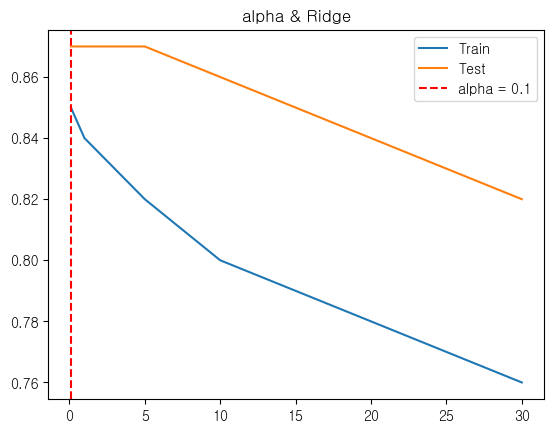

In [168]:
# 학습 및 테스트 점수 시각화
plt.plot(alphas, ridge_score[0], label = 'Train')
plt.plot(alphas, ridge_score[1], label = 'Test')
plt.axvline(best_alpha, linestyle = '--', color = 'red', label = f'alpha = {best_alpha}')
plt.legend()
plt.title('alpha & Ridge')
plt.show()

In [169]:
# 라쏘 최적의 규제 강도 설정 값 찾기
alphas = [0.1, 1., 5., 10., 15., 20., 25., 30.,]

lasso_score = [[], []]
for a in alphas:
    result = score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Lasso(alpha = a))

    lasso_score[0].append(result[0])
    lasso_score[1].append(result[1])

In [170]:
# 테스트 점수가 가장 높은 alpha
best_alpha = alphas[lasso_score[1].index(max(lasso_score[1]))]
max(lasso_score[1])

0.85

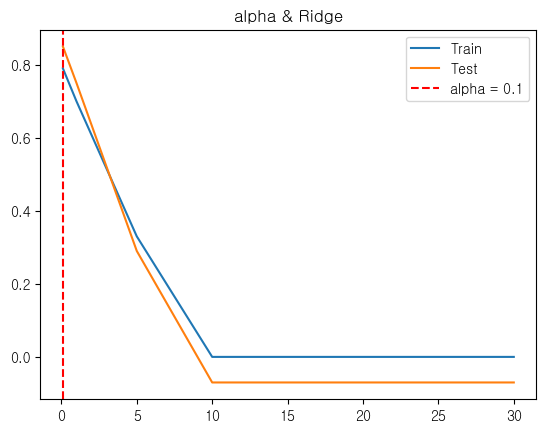

In [171]:
# 학습 및 테스트 점수 시각화
plt.plot(alphas, lasso_score[0], label = 'Train')
plt.plot(alphas, lasso_score[1], label = 'Test')
plt.axvline(best_alpha, linestyle = '--', color = 'red', label = f'alpha = {best_alpha}')
plt.legend()
plt.title('alpha & Ridge')
plt.show()

In [172]:
# 엘라스틱넷 최적의 규제 강도 설정 값 찾기
alphas = [0.1, 1., 5., 10., 15., 20., 25., 30.,]

ela_score = [[], []]
for a in alphas:
    result = score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, ElasticNet(alpha = a, l1_ratio = 0.3))

    ela_score[0].append(result[0])
    ela_score[1].append(result[1])

In [173]:
# 테스트 점수가 가장 높은 alpha
best_alpha = alphas[ela_score[1].index(max(ela_score[1]))]
max(ela_score[1])

0.82

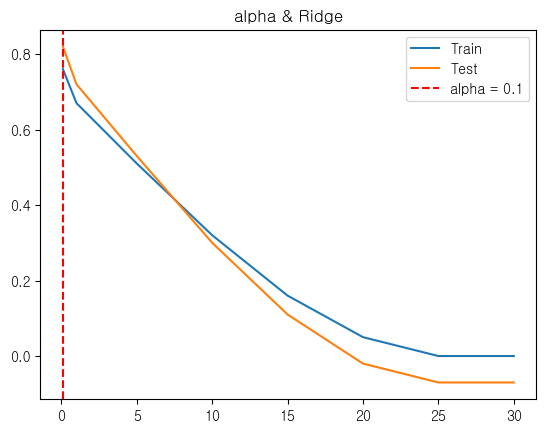

In [174]:
# 학습 및 테스트 점수 시각화
plt.plot(alphas, ela_score[0], label = 'Train')
plt.plot(alphas, ela_score[1], label = 'Test')
plt.axvline(best_alpha, linestyle = '--', color = 'red', label = f'alpha = {best_alpha}')
plt.legend()
plt.title('alpha & Ridge')
plt.show()

#### 다중 공선성을 고려하여 특성 3개 데이터만 추출

In [175]:
featureDF = houseDF[['RM', 'PTRATIO', 'LSTAT']].dropna()
#targetSR = houseDF[featureDF.index]['MEDV']
targetSR = houseDF.iloc[featureDF.index]['MEDV']


In [176]:
# 인덱스 재조정 => 0부터 순차적으로
featureDF.reset_index(drop = True, inplace = True)
targetSR.reset_index(drop = True, inplace = True)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 6)

In [178]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [179]:
std_scaler.fit(X_train)
scaled_X_train = std_scaler.transform(X_train)
scaled_X_test = std_scaler.transform(X_test)

In [180]:
lr_model = LinearRegression()
lr_model.fit(scaled_X_train, y_train)
lr_model.score(scaled_X_test, y_test)

0.6735137090383694

In [181]:
# 모델 파라미터
print(lr_model.coef_, lr_model.intercept_)

[ 2.99088487 -1.84229639 -4.40612593] 22.515979381443294


In [182]:
y_pre1 = lr_model.predict(scaled_X_test)

In [183]:
print(r2_score(y_pre1, y_test), mean_absolute_error(y_pre1, y_test), mean_squared_error(y_pre1, y_test))

0.5272650240010586 3.8593434456808984 24.882592090990737


In [184]:
ridge_model = Ridge(alpha = 100)
ridge_model.fit(scaled_X_train, y_train)
ridge_model.score(scaled_X_test, y_test)

0.6716053780827353

In [185]:
# 모델 파라미터
print(ridge_model.coef_, ridge_model.intercept_)

[ 2.77336635 -1.77868117 -3.62822071] 22.515979381443294


In [186]:
y_pre2 = ridge_model.predict(scaled_X_test)

In [187]:
print(r2_score(y_pre2, y_test), mean_absolute_error(y_pre2, y_test), mean_squared_error(y_pre2, y_test))

0.39081547977305775 3.808147532259273 25.028032258183647


In [188]:
lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(scaled_X_train, y_train)
lasso_model.score(scaled_X_test, y_test)

0.6726851513794865

In [189]:
# 모델 파라미터
print(lasso_model.coef_, lasso_model.intercept_)

[ 2.94417941 -1.77936516 -4.35941549] 22.515979381443294


In [190]:
y_pre3 = ridge_model.predict(scaled_X_test)

In [191]:
print(r2_score(y_pre3, y_test), mean_absolute_error(y_pre3, y_test), mean_squared_error(y_pre3, y_test))

0.39081547977305775 3.808147532259273 25.028032258183647


In [192]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, degree, my_model = LinearRegression(), test_size = 0.2, random_state = 42, df = houseDF):
    featureDF = df[feature]
    targetSR = df[target]
    # 결측치가 하나라도 있는 행은 제거한 나머지 추출
    featureDF = featureDF.dropna()

    # 타겟시리즈에 위 피처데이터의 인덱스 정보를 넣어서 추출
    targetSR = targetSR[featureDF.index]

    # 인덱스 재조정 => 0부터 순차적으로
    featureDF.reset_index(drop = True, inplace = True)
    targetSR.reset_index(drop = True, inplace = True)
    
    # 피처 추가
    poly = PolynomialFeatures(include_bias = False, degree = degree)
    poly.fit(featureDF)  # fit에 넣을 데이터는 2차원이어야 한다.
    poly_data = poly.transform(featureDF)
    poly_feature_names = poly.get_feature_names_out(featureDF.columns)
    new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
    new_df = pd.concat([new_df, targetSR], axis = 1)
    featureDF = new_df[new_df.columns[:-1]]
    targetDF = new_df[target] 
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = test_size, random_state = random_state)
    my_scaler.fit(X_train)
    scaled_X_train = my_scaler.transform(X_train)
    scaled_X_test = my_scaler.transform(X_test)

    my_model.fit(scaled_X_train, y_train)
    return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

In [193]:
# LinearRegression
score_return(['RM', 'PTRATIO', 'LSTAT'], 'MEDV', StandardScaler(), 2)

(0.79, 0.85)

In [194]:
score_return(['RM', 'PTRATIO', 'LSTAT'], 'MEDV', StandardScaler(), 2, Ridge())

(0.78, 0.84)

In [195]:
score_return(['RM', 'PTRATIO', 'LSTAT'], 'MEDV', StandardScaler(), 2, Lasso())

(0.7, 0.77)